In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(doParallel)
library(rwantshue)
library(RColorBrewer)
library(vegan)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked fro

In [4]:
import pandas as pd

In [5]:
# I need to take the OTU ID from my mapped file, and get the genus it was assigned,
# Look up that genus in the rrnDB to get the copy number that corresponds
# Assign that abundance number to the OTU and get its differential abundance

In [6]:
rrnDB = pd.read_table("../../SeqData/rrnDB-4.4.3_pantaxa_stats_RDP.tsv")

In [7]:
rrnDB_d = {}
names = rrnDB[rrnDB["rank"]=="genus"]["name"]
copynum = rrnDB[rrnDB["rank"]=="genus"]["mean"]
for i in range(0,len(names)-1):
    rrnDB_d[names[i]]=copynum[i]
# Now we have the dictionary of the rrnDB database, for which we can look up values of 16S copy number.

In [8]:
OTUs2 = pd.read_table("../../SeqData/otus.pick.fasta.rrndp.tsv", sep="\t", header=None)

In [9]:
fh = open("../../SeqData/otus.pick.fasta.rrndp.tsv","r")
output_fh = open("../../SeqData/otus.genuses.csv","w")
for line in fh:
    ourlist = line.split()
    genus = "genus"
    if genus in ourlist:
        genusindex = ourlist.index(genus)
        OTU = ourlist[0]
        genusname = ourlist[genusindex-1]
        if genusname in rrnDB_d.keys():
            copynum = str(rrnDB_d[genusname])
        else:
            copynum = "NA"
        output_fh.write(str(OTU+","+genusname+","+copynum+"\n"))
fh.close()
output_fh.close()

Now we have a file with the OTU IDs, and the predicted copy number, if available

In [4]:
%%R
#l2fc = read.csv("../../SeqData/l2fc.csv")
l2fc = read.csv("../../SeqData/l2fcCombMonths.csv")

In [5]:
%%R
copynum = read.csv("../../SeqData/otus.genuses.csv", header=FALSE, col.names = c("OTU","Genus","Copynum"))

In [6]:
%%R
validOTUs = copynum$OTU
l2fcOTUs = unique(l2fc$OTU)
l2fc$Copynum = "NA"
i=0
while (i <= length(l2fcOTUs)) {
    OTU = paste(l2fcOTUs[i]);
    l2fc[l2fc$OTU==OTU,16] = copynum[copynum$OTU==OTU,]$Copynum;
    i=i+1
}

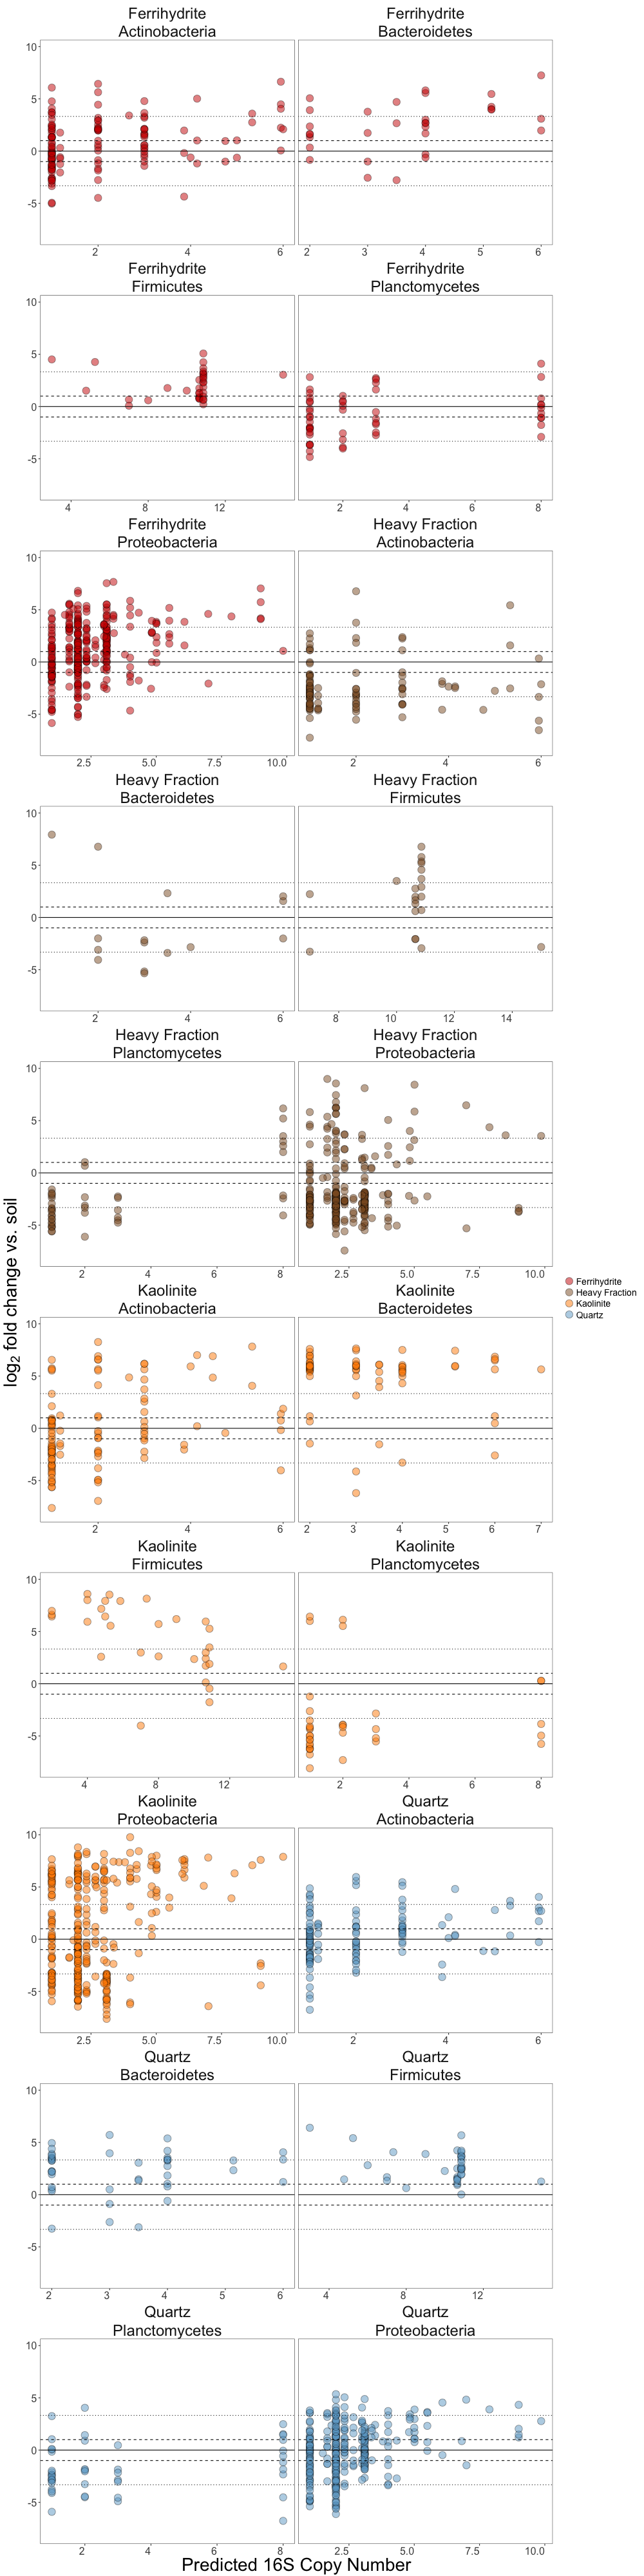

In [7]:
%%R -w 1000 -h 4000
# setting the image sizes, then making the figure...

FDR = 0.1
cutoff = 0

d = l2fc
d$Copynum = as.numeric(d$Copynum)

n=10
ComPhy = d%>%
    group_by(Phylum)%>%
    summarize(Count=n())%>%
    arrange(-Count)
ComPhy = ComPhy[1:n,]$Phylum
ComPhy = droplevels(ComPhy)

MultCopyNumPhyla = c("Actinobacteria", "Bacteroidetes", "Firmicutes" , "Planctomycetes", "Proteobacteria")

d = group_by(d, Trtmt) %>%
#    mutate(sig = ifelse(padj<FDR,1,0))%>%
#    filter(sig==1)%>%
    filter(pvalue != 'NA')%>%
#    filter(Phylum=="Proteobacteria")%>%
#    filter(l2FC>cutoff)%>%
    filter(Copynum != "NA")%>%
#    mutate(CommonPhyla=ifelse(Phylum %in% ComPhy, paste(Phylum), "Other"))
    mutate(CommonPhyla=ifelse(Phylum %in% MultCopyNumPhyla, paste(Phylum), "Other"))%>%
# This compares it to the whole sample, not just the signficantly increased subset in l2fc
    filter(CommonPhyla!="Other")
  
#d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
    
p = ggplot(d, aes(x = Copynum, y = l2FC, fill=Trtmt))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_grid(~Trtmt, scales="free_x")
p = p + facet_wrap(~Trtmt+CommonPhyla, scales="free_x", ncol=2)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

From looking at this, we can see the following phyla have 4 or more 16S copy numbers:

Actinomycetes, Bacteroidetes, Firmicutes Planctomycetes, and Proteobacteria

We want to know:
1) If there is a significant correlation between 16S copy number and l2fc. (test for slope)
2) If this relationship differs across minerals, for a given phylum (test for interaction)

In [56]:
%%R
ggsave(filename="16SCopyNum.AGU.jpg", plot=p ,width=8, height=7)

Maybe what we really want to know is, is the likelihood of enrichment greater at higher copy numbers? Not necessarily a linear correlation.

Could potentially test to see if, as copynum increases, DA is more likely to be positive?

# Statistics

In [135]:
%%R
d = l2fc%>%
#    filter(Phylum!="Firmicutes")%>%
    filter(Trtmt=="Ferrihydrite")%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))

da.lm=lm(data=d,l2FC~Copynum+Phylum)
da.summary = summary.lm(da.lm)
b=da.summary$coefficients[1,1]
m=da.summary$coefficients[2,1]
da.summary


Call:
lm(formula = l2FC ~ Copynum + Phylum, data = d)

Residuals:
   Min     1Q Median     3Q    Max 
-6.722 -1.521  0.000  1.653  6.622 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.79120    1.70167   1.053  0.29282    
Copynum                 0.36685    0.05742   6.389 2.77e-10 ***
PhylumAcidobacteria    -1.23583    2.19218  -0.564  0.57308    
PhylumActinobacteria   -1.81438    1.71063  -1.061  0.28916    
PhylumAD3              -7.89014    2.94291  -2.681  0.00748 ** 
PhylumAquificae         0.01082    2.40121   0.005  0.99641    
PhylumArmatimonadetes  -3.55282    2.08016  -1.708  0.08802 .  
PhylumBacteroidetes    -0.43495    1.74082  -0.250  0.80276    
PhylumChlamydiae       -2.52678    1.73037  -1.460  0.14460    
PhylumChlorobi         -2.72611    1.87725  -1.452  0.14683    
PhylumChloroflexi      -2.58646    1.73708  -1.489  0.13687    
PhylumCrenarchaeota    -1.55270    1.96128  -0.792  0.42877    
PhylumCyanobac

In [115]:
%%R
d = l2fc%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))
    
da.aov=aov(data=d,l2FC~Copynum+Trtmt+Copynum*Trtmt)
da.summary = summary.aov(da.aov)
da.summary

                Df Sum Sq Mean Sq F value  Pr(>F)    
Copynum          1   1996  1996.1 189.555 < 2e-16 ***
Trtmt            3   3696  1232.1 117.005 < 2e-16 ***
Copynum:Trtmt    3    138    46.1   4.376 0.00442 ** 
Residuals     3040  32013    10.5                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
%%R
d = l2fc%>%
    #filter(padj<0.1)
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))
    
da.aov=aov(data=d,l2FC~Copynum+Trtmt+Copynum*Trtmt)
da.summary = summary.aov(da.aov)
da.summary

                Df Sum Sq Mean Sq F value  Pr(>F)    
Copynum          1   1996  1996.1 189.555 < 2e-16 ***
Trtmt            3   3696  1232.1 117.005 < 2e-16 ***
Copynum:Trtmt    3    138    46.1   4.376 0.00442 ** 
Residuals     3040  32013    10.5                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
%%R
d = l2fc%>%
    filter(Trtmt=="Kaolinite")%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))
    
da.aov=aov(data=d,l2FC~Copynum)
da.summary = summary.aov(da.aov)
da.summary

             Df Sum Sq Mean Sq F value   Pr(>F)    
Copynum       1    925   925.3   44.21 5.49e-11 ***
Residuals   793  16598    20.9                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [122]:
%%R
d = l2fc%>%
    filter(Trtmt=="Kaolinite")%>%
    filter(is.na(Copynum)==FALSE)%>%
    mutate(Copynum=as.numeric(Copynum))

da.lm=lm(data=d,l2FC~Copynum)
da.summary = summary.lm(da.lm)
b=da.summary$coefficients[1,1]
m=da.summary$coefficients[2,1]
da.summary


Call:
lm(formula = l2FC ~ Copynum, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1759 -2.6749 -0.2444  2.3455  9.3366 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.64362    0.09794  -6.571 5.84e-11 ***
Copynum      0.38035    0.02920  13.024  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.431 on 3046 degrees of freedom
Multiple R-squared:  0.05275,	Adjusted R-squared:  0.05244 
F-statistic: 169.6 on 1 and 3046 DF,  p-value: < 2.2e-16



### Linear models with statistical consulting

Actinomycetes, Bacteroidetes, Firmicutes Planctomycetes, and Proteobacteria

In [104]:
%%R

FDR = 0.1

d = l2fc
d$Copynum = as.numeric(d$Copynum)


d = group_by(d, Trtmt) %>%
    mutate(sig = ifelse(padj<FDR,1,0))%>%
    filter(pvalue != 'NA')%>%
    filter(Copynum != "NA")%>%
    #filter(Trtmt != "Kaolinite")%>%
    mutate(CommonPhyla=ifelse(Phylum %in% ComPhy, paste(Phylum), "Other"))

head(d)
## Choose a subset of phyla - ideally ~8 different 16S copy numbers...
# Based on variogram results below, there is not strong evidence that closely related OTUs 
# have more similar l2FC values. So, we can treat the OTUs as being separate data points.
# I do wonder what it would be like if we took the mean value of l2fc for each copy number, by mineral.
# I'll try that below

Source: local data frame [6 x 18]
Groups: Trtmt [1]

   Trtmt        OTU  baseMean      l2FC        SE     pvalue  Kingdom
  <fctr>     <fctr>     <dbl>     <dbl>     <dbl>      <dbl>   <fctr>
1 Quartz   58_38953 1.8800536 3.4731449 1.3833426 0.01204953 Bacteria
2 Quartz   73_37380 4.9772368 1.7161017 1.8879580 0.36336472 Bacteria
3 Quartz   89_15230 2.0957988 1.6238517 1.2504180 0.19406509 Bacteria
4 Quartz    58_1575 5.0741672 0.9004553 0.8968249 0.31535547 Bacteria
5 Quartz 75.2_52277 0.6717111 3.3560555 2.0160881 0.09598514 Bacteria
6 Quartz   71_98852 0.6031261 3.2403288 2.0234018 0.10928254 Bacteria
# ... with 11 more variables: Phylum <fctr>, Class <fctr>, Order <fctr>,
#   Family <fctr>, Genus <fctr>, Species <fctr>, Total <dbl>, padj <dbl>,
#   Copynum <dbl>, sig <dbl>, CommonPhyla <chr>


In [105]:
%%R
MultCopyNumPhyla = c("Actinobacteria", "Bacteroidetes", "Firmicutes" , "Planctomycetes", "Proteobacteria")

d2 = d %>%
    filter(Phylum %in% MultCopyNumPhyla)#%>%
#    filter(Trtmt=="Kaolinite"||Trtmt=="Quartz")

In [114]:
%%R
model = lm(l2FC~Copynum,data=d2)
summary(model)
# No interaction for Actinos (+ slope) or Proteobacteria (+ slope)
# Interaction for Kaolinite for Bacteroidetes (+ slope) and Firmicutes (- slope)
# Interaction for HF for Planctomycetes (+ slope)


Call:
lm(formula = l2FC ~ Copynum, data = d2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9658 -2.5227 -0.2304  2.1806  9.1532 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.78501    0.11557  -6.793 1.42e-11 ***
Copynum      0.37177    0.03093  12.018  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.352 on 2150 degrees of freedom
Multiple R-squared:  0.06295,	Adjusted R-squared:  0.06252 
F-statistic: 144.4 on 1 and 2150 DF,  p-value: < 2.2e-16



In [118]:
%%R
model = lm(l2FC~Copynum*Phylum,data=d)
summary(model)


Call:
lm(formula = l2FC ~ Copynum * Phylum, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2500 -2.1890 -0.1463  1.9438 10.3904 

Coefficients: (9 not defined because of singularities)
                                Estimate Std. Error t value Pr(>|t|)   
(Intercept)                      2.61830    3.91008   0.670  0.50315   
Copynum                          0.84598    1.18667   0.713  0.47596   
PhylumAcidobacteria             -1.53498    4.24542  -0.362  0.71771   
PhylumActinobacteria            -4.01038    3.91825  -1.024  0.30615   
PhylumAD3                       -6.53992    2.19728  -2.976  0.00294 **
PhylumAquificae                 -1.75592    5.71261  -0.307  0.75858   
PhylumArmatimonadetes          -13.95851    5.28863  -2.639  0.00835 **
PhylumBacteroidetes              0.39225    3.96814   0.099  0.92126   
PhylumChlamydiae                -4.40896    3.96917  -1.111  0.26675   
PhylumChlorobi                  -2.44385    4.12636  -0.592  0.55373   
Phy

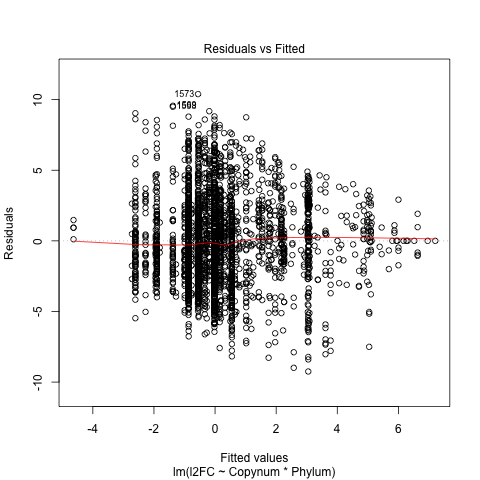

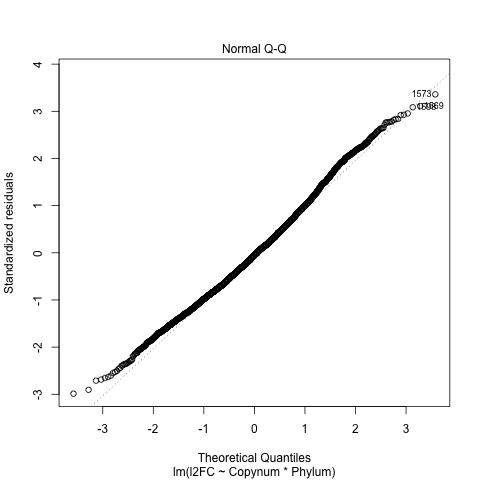

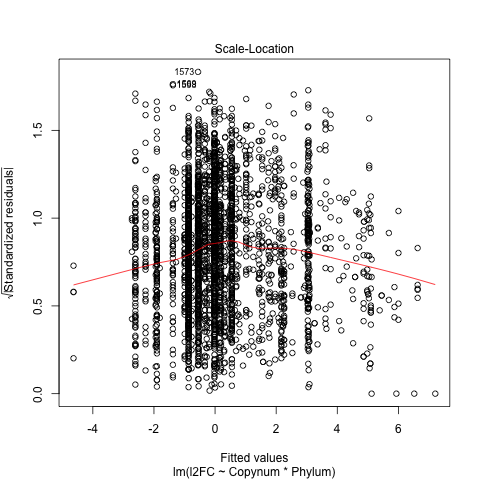

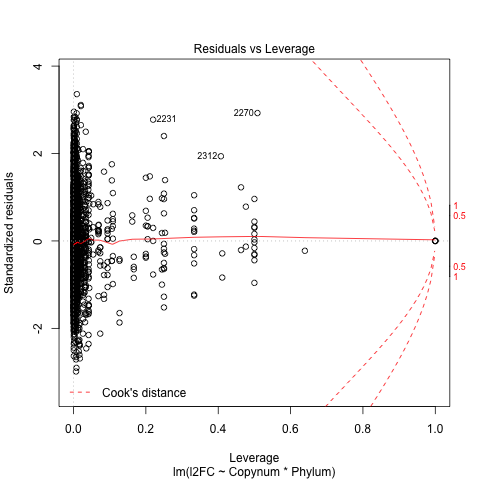

In [119]:
%%R
plot(model)
# want spread similar (resid vs pred)
# Want line ~flat

In [ ]:
# Slopes are ~the same between the two minerals, 
# Start with interaction p val first (slopes different?)
# If not, then drop it, run model without interaction

# For overall F-test, would need to run ANOVA to evaluate whether diffs btwn slopes

## Constructing variogram after statistical consulting appt

Independence — Variograms (or correllellogram) - does variance (similarity of residuals for each spp compared to each other, for varying levels of closeness) increase as points(species) get further apart (phylogenetically)?  Then, do residuals 

	-geoR does this for geog stuff - wants x-y coords or distance matrix directly
    
	-plot var vs. distance
    
		-Spatial autocorrelation function between the two
        
			-Range: where is ~95-100% of max variance achieved? - basically not correlated at this point
            
			-Then, you could choose some method of … averaging species, or selecting one randomly and using that as representative
            
			-But if no correlation, then that’s great
            
	-Typical LR model assumes independence - if you do the variogram, you could use that information to build the linear model with that info.

Goal: compare each species to each other species. Note the phylogenetic distance between each one. Then, bin those distances into groups.

The x-axis will be the distance between species. The variance, I'm not totally clear on. It's the residuals for each pair of species? Or, maybe, like, you 

Average one-half the difference squared of the z-values over all pairs of observations within that range.
So, like, take the observations (l2FC), for each pair, and take the squared difference between the two. Have a second  data matrix that represents that. Add up all the squared comparisons, and divide it by 2N, where N is the number of pairs we considered. I think I can make that happen. Then plot that against the distance bins.

So, first step, calculate distance matrix (phylogenetic distance) between all species.

Second step, calculate the square of the distance between the two samples' values of l2FC.

Third step, choose some distance bins, and then pull out the average(/2N) of squared l2FC distances for each bin.

Plot the bin distances against these values.

In [11]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)
library(picante)
library(ape)
library(reshape)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ape

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: nlme

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘nlme’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    collapse


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:IRanges’:

    collapse


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRunt

In [12]:
%%R
# Pulling in and converting the tree file to "phylo" format
MyTree = read.tree("../../SeqData/fulltree.tre")
Tips = MyTree$tip.label
NewTips = gsub('\'',"",Tips)
MyTree$tip.label = gsub("\'","",MyTree$tip.label)

In [13]:
%%R
physeq = import_biom("../../../16S/SeqData/otu_table.tax.meta.biom", tree = "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [14]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged
physeq = subset_samples(physeq,sample_sums(physeq)>1500)
physeq = subset_samples(physeq, sample_data(physeq)$Month != 2.0)

In [15]:
%%R
Comm = as.data.frame(otu_table(physeq))
# Takes the OTU table out of its physeq object and stores it as a data frame

In [16]:
%%R
dis = cophenetic(MyTree)
# Should calculate pairwise distances between each species in my 

In [17]:
%%R
dim(dis)
# Looks like right dimensions

[1] 9190 9190


In [18]:
%%R
# Need to get the l2FC values... they were calculated separately for each mineral.
# So I might need to make this graph for each mineral. That would be okay, I think.
# I need a table with all the OTUs, and their l2FC for each mineral.

NULL


In [19]:
%%R
l2fc<-read.csv("../../SeqData/l2fcCombMonths.csv")
l2fc.trim = cast(l2fc,OTU~Trtmt)
rownames(l2fc.trim)=l2fc.trim$OTU
l2fc.trim = l2fc.trim[2:5]
colnames(l2fc.trim)[2]="HeavyFraction"
head(l2fc.trim)
# Creates table of OTUs and the l2FC for each mineral.
# So, for each column, I could make a distance matrix
# I'll want the OTUs in the same order as the dis.trim matrix

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using padj as value column.  Use the value argument to cast to override this choice

  warnings.warn(x, RRuntimeWarning)


         Ferrihydrite HeavyFraction  Kaolinite     Quartz
1_10014    0.48525508     0.5579075 0.81134041 0.88580977
1_106685   0.03749919     0.4744406 0.04025224 0.05655703
1_11013    0.03520500            NA         NA         NA
1_11342    0.43075107            NA         NA         NA
1_118229   0.18861897     0.5521301 0.16999095 0.09682323
1_11967    0.91025459     0.5463369         NA 0.13836125


In [20]:
%%R
# There were only 3840 OTUs that got l2FC values. We could trim the phylogenetic distance to these.
OTUs.l2fc = rownames(l2fc.trim)
dis.trim = dis[rownames(dis) %in% OTUs.l2fc,colnames(dis) %in% OTUs.l2fc]
dim(dis.trim)
# That seems to have worked. Trimmed distance matrix.
dis.trim = dis.trim[order(rownames(dis.trim)),order(colnames(dis.trim))]
# Ordering same as l2fc.trim

In [21]:
%%R

squardist = function(i,j){(i-j)^2}
# Creates function that finds square of difference between two variables

squardistmtx = function(Trtmt){
    name = eval(parse(text = paste("l2fc.trim$",Trtmt, sep="")))
    OTUs = rownames(l2fc.trim)
    as.name(paste("l2fc.trim$",paste(Trtmt), sep=""))
    resultname = outer(name,name,squardist)
    rownames(resultname) = OTUs
    colnames(resultname) = OTUs
    return(resultname)
}
# Runs the matrix function, given a mineral

In [22]:
%%R
head(l2fc.trim$Ferrihydrite)

[1] 0.48525508 0.03749919 0.03520500 0.43075107 0.18861897 0.91025459


In [23]:
%%R
(0.48525508-0.43075107)^2
# Looks like this function is doing the right thing too.

[1] 0.002970687


In [24]:
%%R

l2fcsquardistmatrix.F = squardistmtx("Ferrihydrite")
l2fcsquardistmatrix.Q = squardistmtx("Quartz")
l2fcsquardistmatrix.H = squardistmtx("HeavyFraction")
l2fcsquardistmatrix.K = squardistmtx("Kaolinite")

# Created all the matrixes
# These should have same ordering as the phylogenetic distance matrix.
# Now I need to make those distance divisions

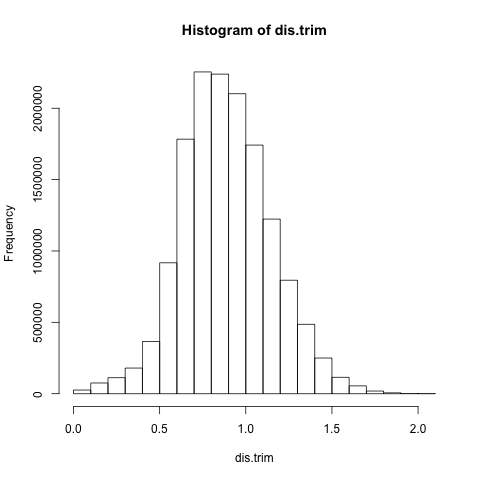

In [25]:
%%R
hist(dis.trim)

In [26]:
# Values vary from 0 to ~2. I could make, say 20 bins?

In [27]:
%%R
nbins = 20
binsize = max(dis.trim)/nbins
bincutoffs = rep(0,nbins)
for(i in 1:20){
    bincutoffs[i]=(i*binsize)
}
bincutoffs=c(0,bincutoffs)
bincutoffs
# Creates vector of the upper bin cutoffs.

 [1] 0.0000000 0.1049755 0.2099510 0.3149265 0.4199020 0.5248775 0.6298530
 [8] 0.7348285 0.8398040 0.9447795 1.0497550 1.1547305 1.2597060 1.3646815
[15] 1.4696570 1.5746325 1.6796080 1.7845835 1.8895590 1.9945345 2.0995100


In [28]:
%%R
n = 2
lowcut = bincutoffs[n-1]
highcut = bincutoffs[n]
TrueMtxLow = dis.trim>lowcut
# Within cutoff
TrueMtxLow[TrueMtxLow==TRUE] = 1
# Turn into 1's and 0's
TrueMtxHigh = dis.trim<highcut
# Within cutoff
TrueMtxHigh[TrueMtxHigh==TRUE] = 1
# Turn into 1's and 0's
TrueMtx = TrueMtxLow + TrueMtxHigh
# Sum both cutoffs
TrueMtx[TrueMtx==1] = 0
TrueMtx[TrueMtx==2] = 1
# If none or 1 true, 0, if both true, 1.
# This is the matrix that shows whether the phydistance falls within our current bin
# True-false matrix of where dis.trim less than our cutoff, in 0's and 1's

l2fcsquardistmatrix.F.bin1 = TrueMtx*l2fcsquardistmatrix.F
# Multiplying the distance matrix by 1 if it's in the cutoff and by 0 if it's not
# These are all the qualifying values for this bin range.

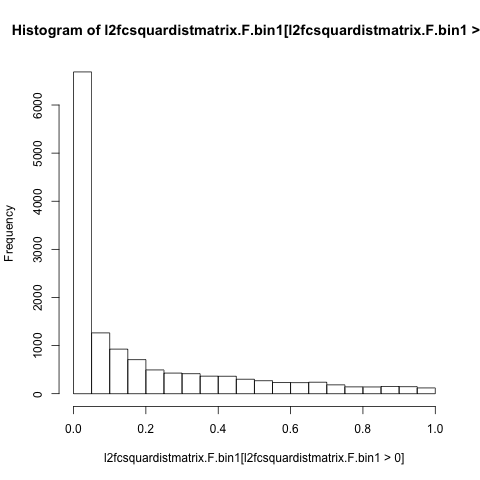

In [29]:
%%R
hist(l2fcsquardistmatrix.F.bin1[l2fcsquardistmatrix.F.bin1>0])
# There are a few non-zero values

In [30]:
%%R
m = c(1,0,3,NA)
m = matrix(m,nrow=2)
sum(m, na.rm=TRUE)
N = sum(m > 0, na.rm=TRUE)
N
# Testing matrix adding elements

[1] 2


In [31]:
%%R
Total = sum(l2FCsquardistmatrix.F.bin1,na.rm=TRUE)
# That's the total distances, which we need to divide by 2N
N = sum(l2FCsquardistmatrix.F.bin1 > 0, na.rm=TRUE)
# Number of non-zero values
Variance = Total / (2*N)
Variance
# This is the value that we would plot for this bin.


Error in withVisible({ : object 'l2FCsquardistmatrix.F.bin1' not found


/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : object 'l2FCsquardistmatrix.F.bin1' not found

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: package ‘ggplot2’ was built under R version 3.3.2 

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In asMethod(object) :
  warnings.warn(x, RRuntimeWarning

In [32]:
%%R
# I could try to make the whole thing into a function.

VCalculator = function(nbins,dis.trim,l2fcsquardistmatrix){
    binsize = max(dis.trim)/nbins
    bincutoffs = rep(0,nbins)
    for(i in 1:20){
        bincutoffs[i]=(i*binsize)
        }
    bincutoffs=c(0,bincutoffs)
    # Calculates bin cutoff ranges
    
    report = data.frame(Upperbin=as.numeric(),Variance=as.numeric(),N=as.numeric())
    
    for(i in 2:nbins){
        lowcut = bincutoffs[i-1]
        highcut = bincutoffs[i]
        TrueMtxLow = dis.trim>lowcut
        # Within cutoff
        TrueMtxLow[TrueMtxLow==TRUE] = 1
        # Turn into 1's and 0's
        TrueMtxHigh = dis.trim<highcut
        # Within cutoff
        TrueMtxHigh[TrueMtxHigh==TRUE] = 1
        # Turn into 1's and 0's
        TrueMtx = TrueMtxLow + TrueMtxHigh
        # Sum both cutoffs
        TrueMtx[TrueMtx==1] = 0
        TrueMtx[TrueMtx==2] = 1 
        l2fcsquardistmatrix.bin = TrueMtx*l2fcsquardistmatrix
        # Multiplying the distance matrix by 1 if it's in the cutoff and by 0 if it's not
        # These are all the qualifying values for this bin range.
        Total = sum(l2fcsquardistmatrix.bin,na.rm=TRUE)
        # That's the total distances, which we need to divide by 2N
        N = sum(l2fcsquardistmatrix.bin > 0, na.rm=TRUE)
        # Number of non-zero values
        Variance = Total / (2*N)
        report[i-1,] = c(bincutoffs[i],Variance,N)

        }
    return(report)
    # We need to do that for every bin size, turn it into the V, and then report the bincutoff value
    # and its corresponding V.
}

In [70]:
%%R
n=10
ReportF = VCalculator(n,dis.trim,l2fcsquardistmatrix.F)
ReportQ = VCalculator(n,dis.trim,l2fcsquardistmatrix.Q)
ReportK = VCalculator(n,dis.trim,l2fcsquardistmatrix.K)
ReportH = VCalculator(n,dis.trim,l2fcsquardistmatrix.H)

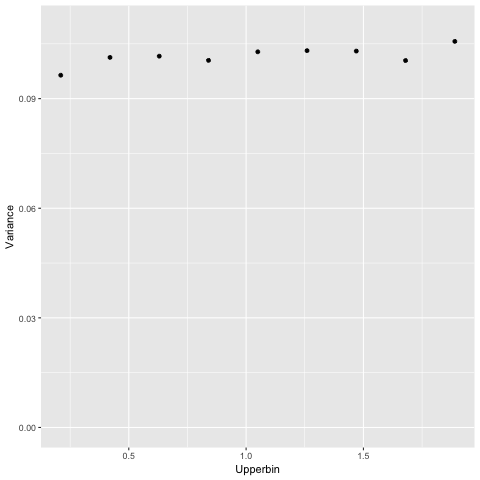

In [86]:
%%R
p = ggplot(ReportQ)
p = p + geom_point(aes(x=Upperbin,y=Variance))
p = p + scale_y_continuous(limits=c(0,0.11))
p

This should be our variogram, where x is phylogenetic distance bins, and y is variance..

It gets weird at high levels, but maybe that's because the N really drops off

We can play around with the number of bins...

Also, putting the scale right makes it look like maybe just noise..

The one weird one is K... seems to decrease.. that seems surprising - response is more similar the less phylogenetically similar the spp are... but maybe thats because of some strane effect - like if there were some outlier species that had a very different response overall.

### I can try this with the geoR package

In [147]:
%%R
#install.packages("geoR")

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: also installing the dependencies ‘RandomFieldsUtils’, ‘splancs’, ‘RandomFields’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: trying URL 'https://cran.mtu.edu/bin/macosx/mavericks/contrib/3.3/RandomFieldsUtils_0.3.15.tgz'

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  length 242790 bytes (237 KB)

  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__

--- Please select a CRAN mirror for use in this session ---

The downloaded binary packages are in
	/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T//RtmpgDNDyN/downloaded_packages


In [ ]:
%%R
library(geoR)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: --------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.7-5.2 (built on 2016-05-02) is now loaded
--------------------------------------------------------------


  warnings.warn(x, RRuntimeWarning)


In [ ]:
%%R
# It wants points, not a distance matrix. So, that's a little complicated.

In [149]:
%%R
#variog(coords=MDS,data=l2fc.trim$Ferrihydrite)

R Help on ‘variog’variog                  package:geoR                   R Documentation

_C_o_m_p_u_t_e _E_m_p_i_r_i_c_a_l _V_a_r_i_o_g_r_a_m_s

_D_e_s_c_r_i_p_t_i_o_n:

     Computes sample (empirical) variograms with options for the
     _classical_ or _robust_ estimators. Output can be returned as a
     ‘binned variogram’, a ‘ variogram cloud’ or a ‘smoothed
     variogram’. Data transformation (Box-Cox) is allowed.  ``Trends''
     can be specified and are fitted by ordinary least squares in which
     case the variograms are computed using the residuals.

_U_s_a_g_e:

     variog(geodata, coords = geodata$coords, data = geodata$data, 
            uvec = "default", breaks = "default",
            trend = "cte", lambda = 1,
            option = c("bin", "cloud", "smooth"),
            estimator.type = c("classical", "modulus"), 
            nugget.tolerance, max.dist, pairs.min = 2,
            bin.cloud = FALSE, direction = "omnidirection

In [ ]:
%%R
#MDS = metaMDS(dis.trim,k=2)
# Should calculate approximate phylogenetic distance coordinates (2 dimensions) for my OTUs
# Pretty hard - trying to fit 3000 species into distance relationships. But should be possible
# Could use this as input in variog
# Keeps getting overloaded and quitting kernel

### Taking only the mean copy number value.

In [161]:
%%R
l2fc = read.csv("../../SeqData/l2fcCombMonths.csv")
copynum = read.csv("../../SeqData/otus.genuses.csv", header=FALSE, col.names = c("OTU","Genus","Copynum"))
validOTUs = copynum$OTU
l2fcOTUs = unique(l2fc$OTU)
l2fc$Copynum = "NA"
i=0
while (i <= length(l2fcOTUs)) {
    OTU = paste(l2fcOTUs[i]);
    l2fc[l2fc$OTU==OTU,16] = copynum[copynum$OTU==OTU,]$Copynum;
    i=i+1
}

In [231]:
%%R
head(l2fc)

   Trtmt      OTU   baseMean      l2FC        SE       pvalue  Kingdom
1 Quartz  69_2370 59.5440236  4.651747 0.6734146 4.925667e-12 Bacteria
2 Quartz 67_26460  0.8162964 -2.052713 1.6220306 2.056849e-01 Bacteria
3 Quartz 96_50315  3.8392939  0.332505 0.9622914 7.296925e-01 Bacteria
4 Quartz 58_38953  1.8800536  3.473145 1.3833426 1.204953e-02 Bacteria
5 Quartz 73_37380  4.9772368  1.716102 1.8879580 3.633647e-01 Bacteria
6 Quartz 65_11911  0.9298593  1.005215 1.4208605 4.792751e-01 Bacteria
          Phylum                 Class             Order             Family
1  Fibrobacteres         Fibrobacteria           258ds10               <NA>
2  Fibrobacteres         Fibrobacteria           258ds10               <NA>
3  Fibrobacteres         Fibrobacteria           258ds10               <NA>
4  Fibrobacteres         Fibrobacteria           258ds10               <NA>
5 Proteobacteria Epsilonproteobacteria Campylobacterales Campylobacteraceae
6 Proteobacteria   Deltaproteobacteria Bdellovi

In [268]:
%%R

l2fc.av = l2fc

l2fc.av$Copynum[is.na(l2fc.av$Copynum)]=0
l2fc.av$Copynum=round(as.numeric(paste(l2fc.av$Copynum)),digits=0)

n=10
ComPhy = l2fc.av%>%
    group_by(Phylum)%>%
    summarize(Count=n())%>%
    arrange(-Count)
ComPhy = ComPhy[1:n,]$Phylum
ComPhy = droplevels(ComPhy)

l2fc.av = l2fc.av%>%
    mutate(CommonPhyla=ifelse(Phylum %in% ComPhy, paste(Phylum), "Other"))


l2fc.av = l2fc.av %>%
    group_by(Trtmt,Copynum)%>%
    summarize(Avel2fc = mean(l2FC), se=sd(l2FC)/sqrt(n()))

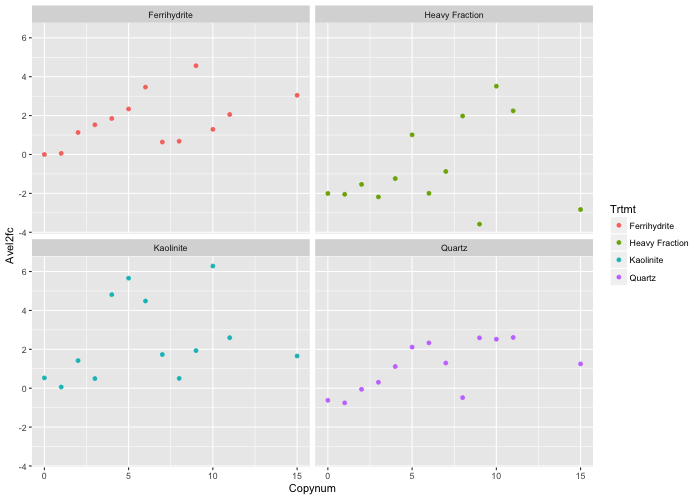

In [270]:
%%R -h 500 -w 700

p = ggplot(l2fc.av)
p = p + geom_point(aes(x=Copynum,y=Avel2fc,colour=Trtmt))
p = p + facet_wrap(~Trtmt)
#p = p + scale_y_continuous(limits=c(0,0.025))
p

In [274]:
%%R
model = lm(Avel2fc~Copynum*Trtmt,data=l2fc.av)
summary(model)


Call:
lm(formula = Avel2fc ~ Copynum * Trtmt, data = l2fc.av)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2883 -1.0264 -0.3084  0.8498  3.7341 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)  
(Intercept)                  0.69980    0.86398   0.810   0.4223  
Copynum                      0.16738    0.11522   1.453   0.1534  
TrtmtHeavy Fraction         -2.28160    1.22185  -1.867   0.0685 .
TrtmtKaolinite               0.99725    1.22185   0.816   0.4188  
TrtmtQuartz                 -0.75390    1.22185  -0.617   0.5404  
Copynum:TrtmtHeavy Fraction -0.03136    0.16294  -0.192   0.8483  
Copynum:TrtmtKaolinite      -0.04269    0.16294  -0.262   0.7945  
Copynum:TrtmtQuartz          0.01675    0.16294   0.103   0.9186  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.733 on 44 degrees of freedom
Multiple R-squared:  0.4188,	Adjusted R-squared:  0.3264 
F-statistic:  4.53 on 7 and 44 DF,  p-value

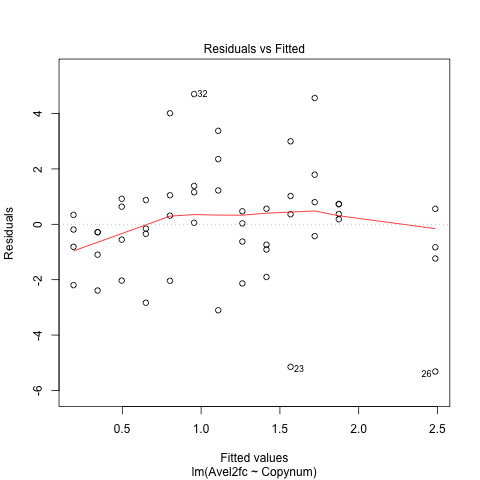

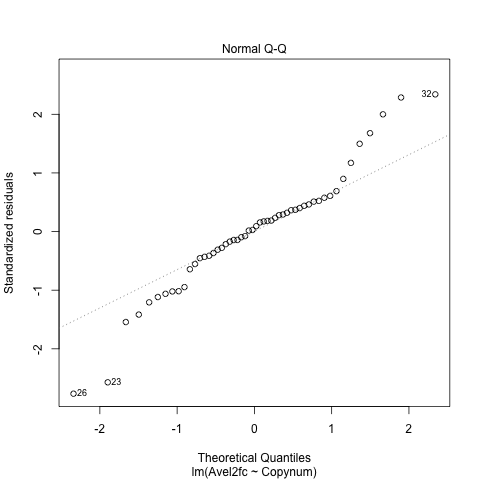

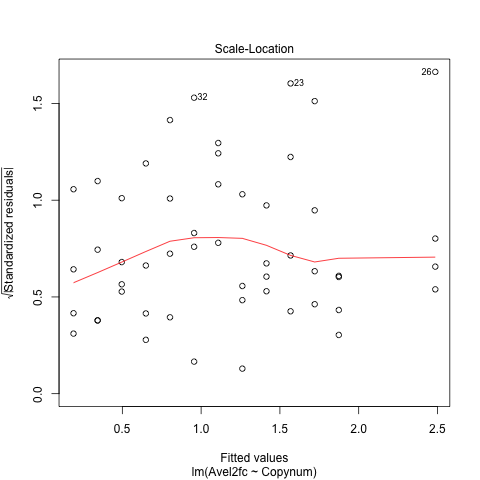

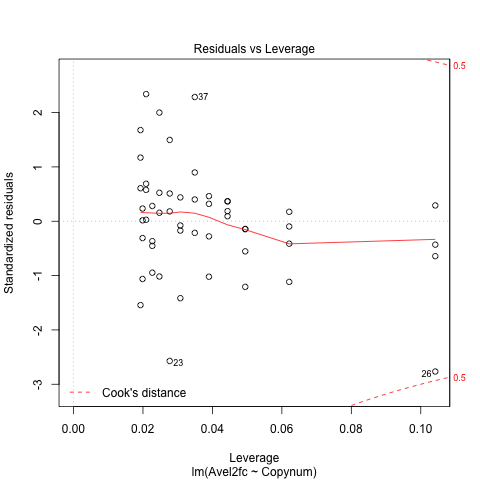

In [273]:
%%R
plot(model)

In [264]:
%%R -h 500 -w 700

l2fc.av = l2fc

l2fc.av$Copynum[is.na(l2fc.av$Copynum)]=0
l2fc.av$Copynum=round(as.numeric(paste(l2fc.av$Copynum)),digits=0)

n=10
ComPhy = l2fc.av%>%
    group_by(Phylum)%>%
    summarize(Count=n())%>%
    arrange(-Count)
ComPhy = ComPhy[1:n,]$Phylum
ComPhy = droplevels(ComPhy)

l2fc.av = l2fc.av%>%
    mutate(CommonPhyla=ifelse(Phylum %in% ComPhy, paste(Phylum), "Other"))

l2fc.av$Copynum = as.factor(l2fc.av$Copynum)

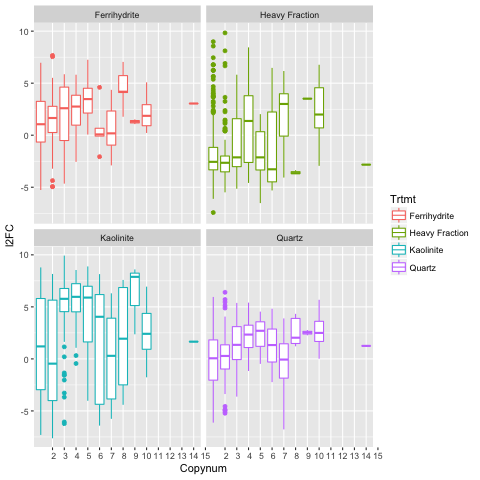

In [265]:
%%R

p = ggplot(l2fc.av)
p = p + geom_boxplot(aes(x=Copynum,y=l2FC,colour=Trtmt),stat="boxplot")
p = p + facet_wrap(~Trtmt)
p = p + scale_x_discrete(limits=c(2:15))
p

### Final stats

We've shown that there's not a strong phylogenetic signal to the data. If we're just interested in whether copynumber is a predictor, and recognizing there may be a mineral interaction, we can calculate a linear model.

In [8]:
%%R

d = l2fc

d = group_by(d, Trtmt) %>%
    filter(Copynum != "NA")%>%
    mutate(CommonPhyla=ifelse(Phylum %in% ComPhy, paste(Phylum), "Other"))

head(d)
## Choose a subset of phyla - ideally ~8 different 16S copy numbers...
# Based on variogram results below, there is not strong evidence that closely related OTUs 
# have more similar l2FC values. So, we can treat the OTUs as being separate data points.
# I do wonder what it would be like if we took the mean value of l2fc for each copy number, by mineral.
# I'll try that below

Source: local data frame [6 x 17]
Groups: Trtmt [1]

   Trtmt        OTU  baseMean      l2FC        SE     pvalue  Kingdom
  <fctr>     <fctr>     <dbl>     <dbl>     <dbl>      <dbl>   <fctr>
1 Quartz   58_38953 1.8800536 3.4731449 1.3833426 0.01204953 Bacteria
2 Quartz   73_37380 4.9772368 1.7161017 1.8879580 0.36336472 Bacteria
3 Quartz   89_15230 2.0957988 1.6238517 1.2504180 0.19406509 Bacteria
4 Quartz    58_1575 5.0741672 0.9004553 0.8968249 0.31535547 Bacteria
5 Quartz 75.2_52277 0.6717111 3.3560555 2.0160881 0.09598514 Bacteria
6 Quartz   71_98852 0.6031261 3.2403288 2.0234018 0.10928254 Bacteria
# ... with 10 more variables: Phylum <fctr>, Class <fctr>, Order <fctr>,
#   Family <fctr>, Genus <fctr>, Species <fctr>, Total <dbl>, padj <dbl>,
#   Copynum <chr>, CommonPhyla <chr>


In [11]:
%%R
d$Copynum = as.numeric(d$Copynum)

In [30]:
%%R

d2 = d

model = lm(l2FC~Copynum+Trtmt*CommonPhyla,data=d2)
summary(model)
# I plotted first a 3-way interaction of Copynum,Trtmt,and CommonPhyla.
# There were no significant 3-way interactions, so I ran the model with all pairwise interactions
# Only Trtmt*Commonphyla had interactions (only ever Kaolinite, with certain phyla)
# We are left with the model of Copynum and a Trtmt*Phylum interaction
# Under this model, Copynum is positive and significant, and Rsq adj is 0.27 - not bad.
# The most effective plot for this would be copynumber vs l2FC, for different combos of Trtmt and Phylum.


Call:
lm(formula = l2FC ~ Copynum + Trtmt * CommonPhyla, data = d2)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.9869  -1.7660  -0.2517   1.7426  10.7630 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                      0.61627    1.73298   0.356
Copynum                                          0.32118    0.03653   8.793
TrtmtHeavy Fraction                             -0.56117    3.46459  -0.162
TrtmtKaolinite                                   2.49852    2.12165   1.178
TrtmtQuartz                                      0.61617    2.29174   0.269
CommonPhylaActinobacteria                       -0.54123    1.75212  -0.309
CommonPhylaBacteroidetes                         0.89952    1.79628   0.501
CommonPhylaChlamydiae                           -1.23766    1.78207  -0.695
CommonPhylaChloroflexi                          -1.34355    1.79171  -0.750
CommonPhylaFirmicutes                           -1.6

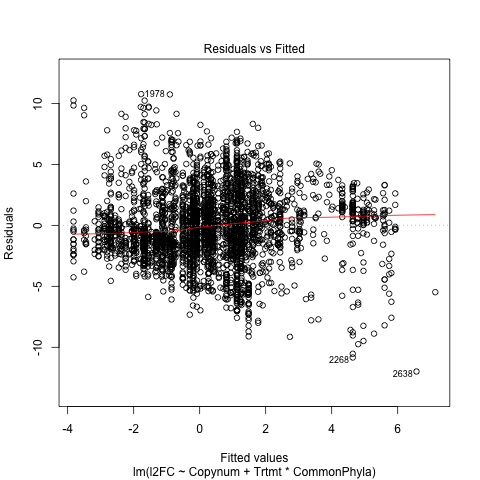

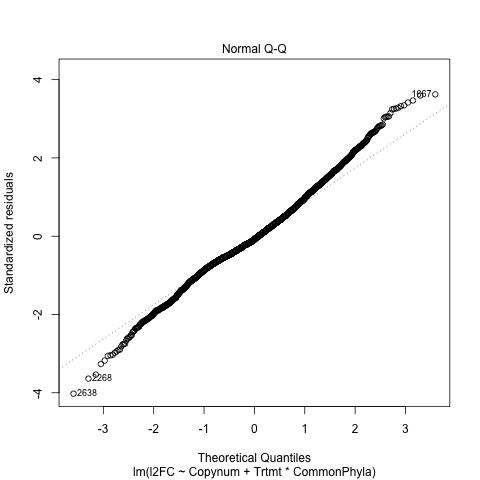

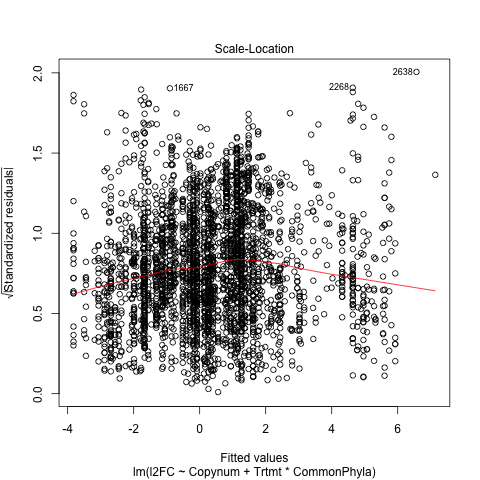

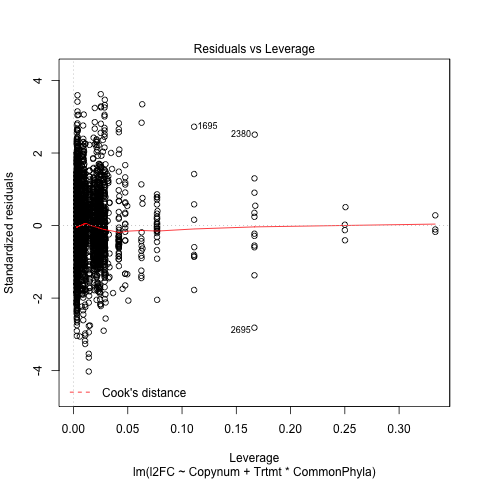

In [31]:
%%R
plot(model)
# Residuals and QQ plot look fine.

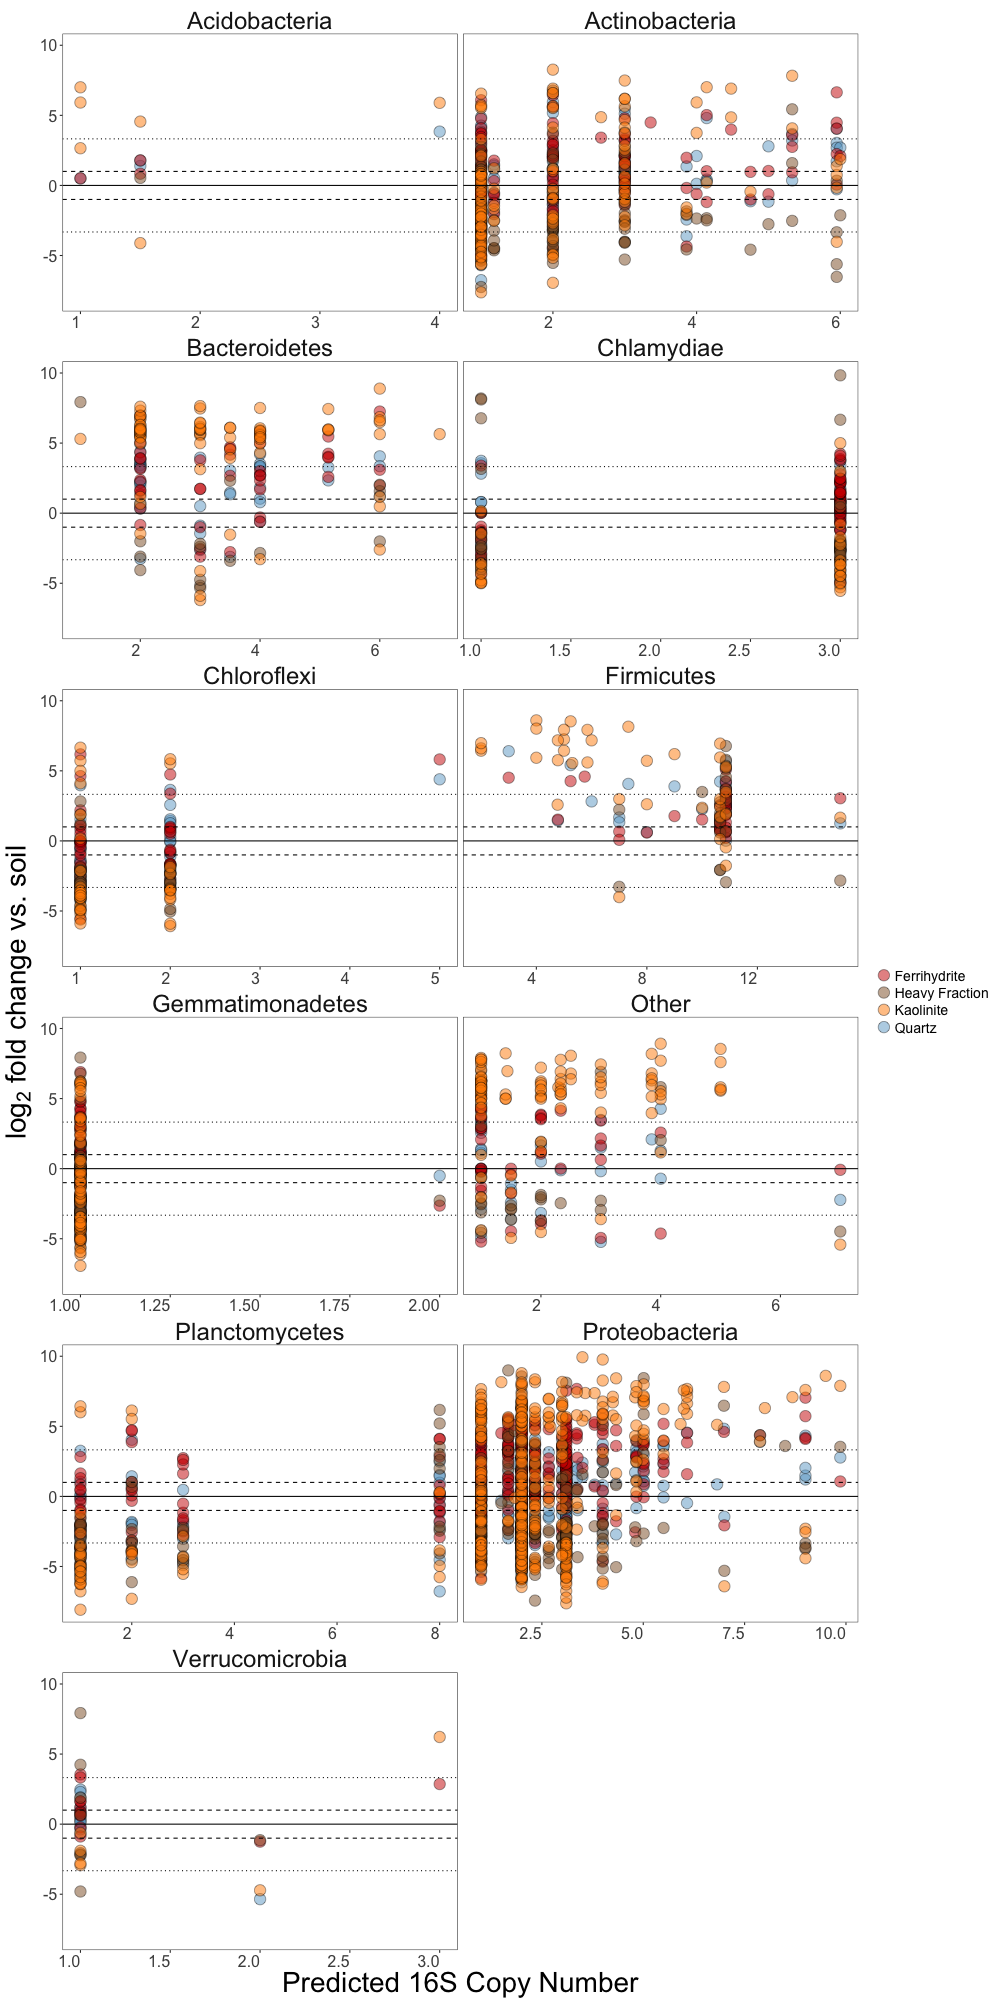

In [32]:
%%R -w 1000 -h 2000
# setting the image sizes, then making the figure...
    
p = ggplot(d2, aes(x = Copynum, y = l2FC, fill=Trtmt))
# establishing our plot is based on the data table d2, with our x being the copynumber, and the y being log2fold change,

p = p + facet_wrap(~CommonPhyla, scales="free_x", ncol=2)
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

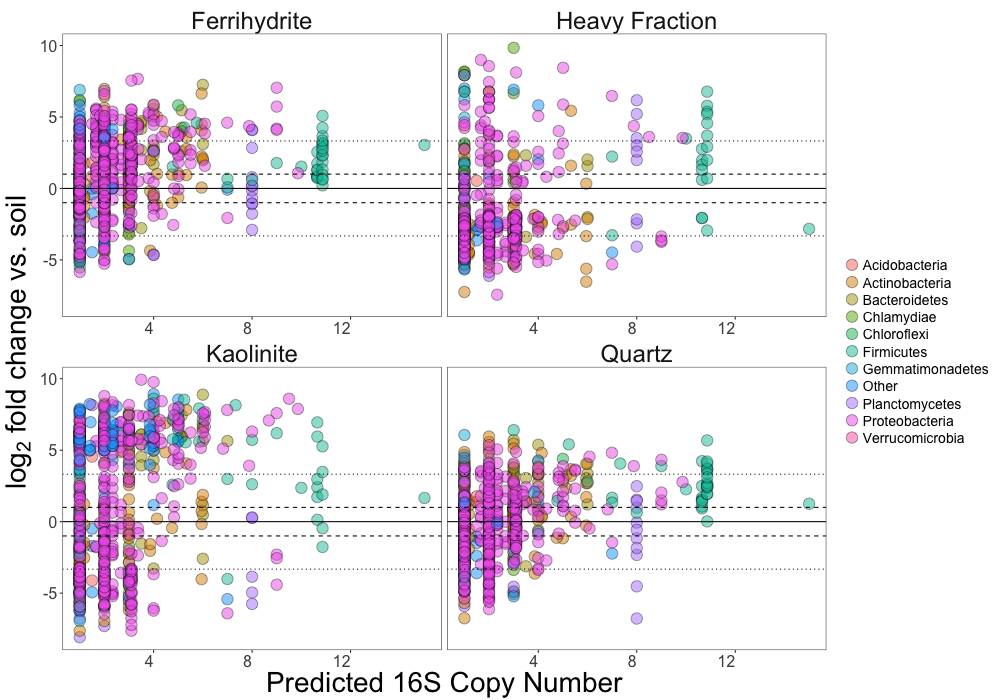

In [352]:
%%R -w 1000 -h 700
# setting the image sizes, then making the figure...


p = ggplot(d, aes(x = Copynum, y = l2FC, fill=CommonPhyla))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_grid(~Trtmt, scales="free_x")
p = p + facet_wrap(~Trtmt, scales="free_x", ncol=2)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

#p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

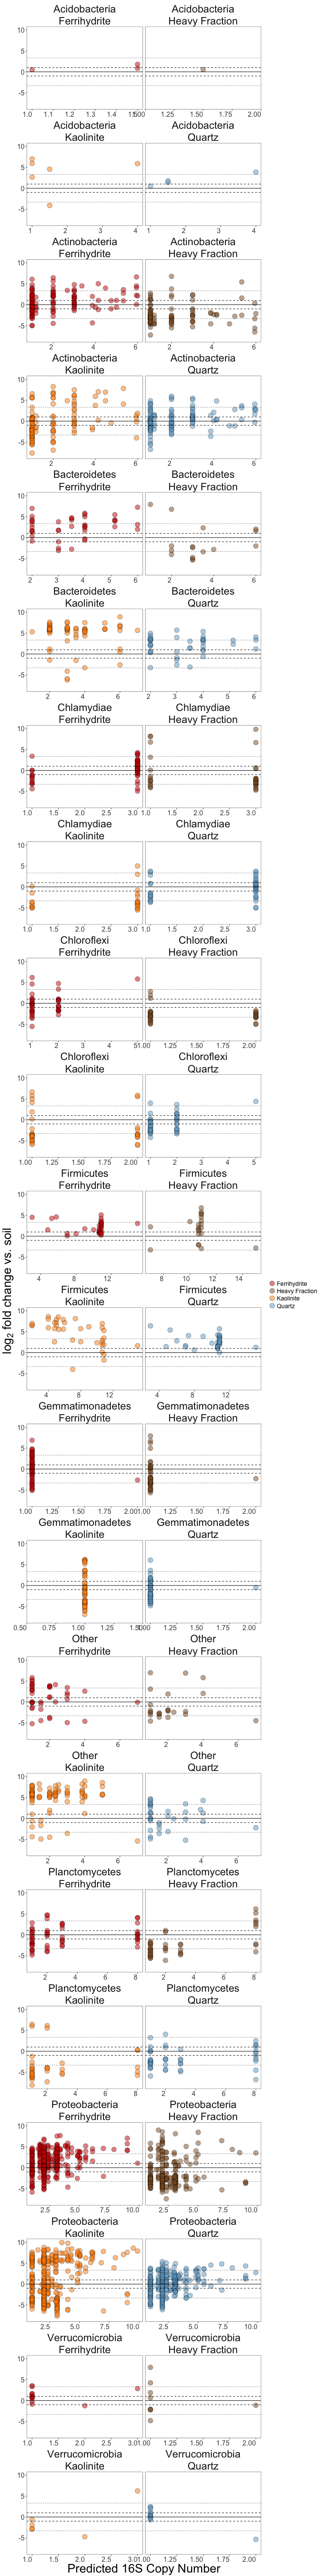

In [353]:
%%R -w 750 -h 6000
# setting the image sizes, then making the figure...
    
p = ggplot(d2, aes(x = Copynum, y = l2FC, fill=Trtmt))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_grid(~Trtmt, scales="free_x")
p = p + facet_wrap(~CommonPhyla~Trtmt, scales="free_x", ncol=2)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

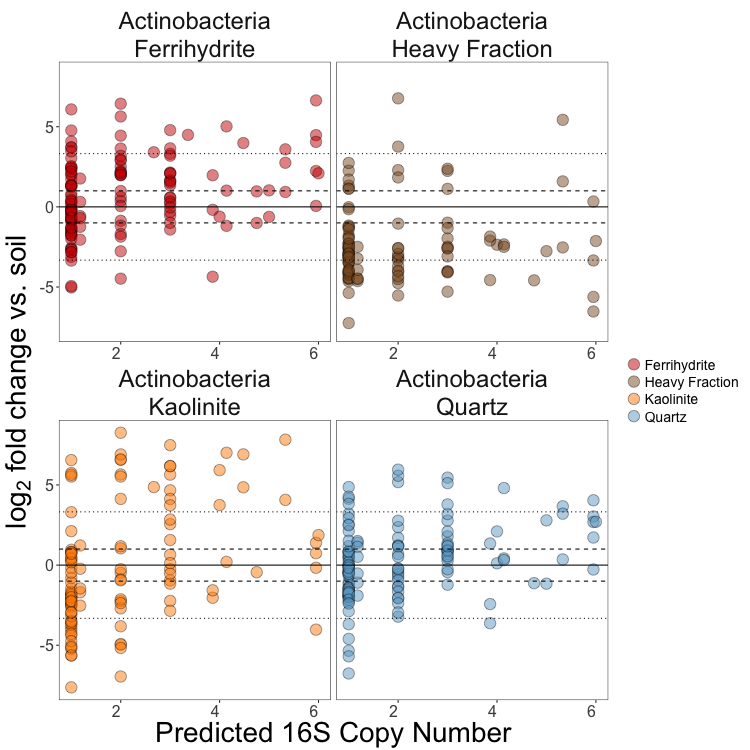

In [338]:
%%R -w 750 -h 750
# setting the image sizes, then making the figure...

d3 = d2 %>%
    filter(CommonPhyla=="Actinobacteria")

p = ggplot(d3, aes(x = Copynum, y = l2FC, fill=Trtmt))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_grid(~Trtmt, scales="free_x")
p = p + facet_wrap(~CommonPhyla~Trtmt, scales="free_x", ncol=2)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

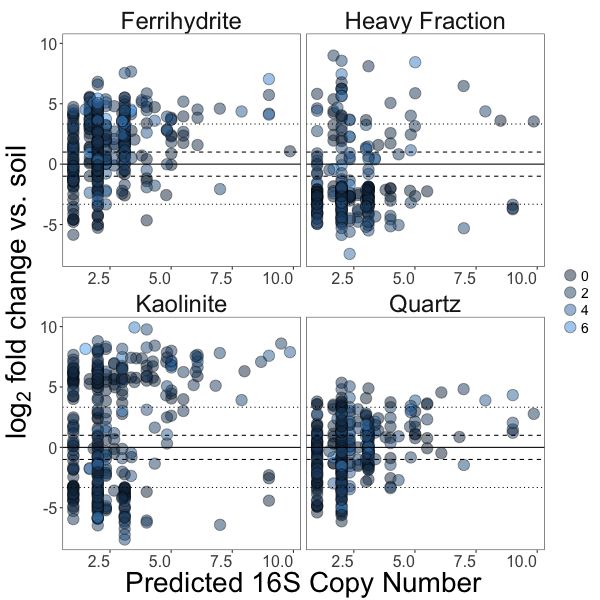

In [360]:
%%R -w 600 -h 600
# setting the image sizes, then making the figure...

d3 = d2 %>%
    filter(CommonPhyla=="Proteobacteria")

p = ggplot(d3, aes(x = Copynum, y = l2FC, fill=log(baseMean)))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

#p = p + facet_grid(~Trtmt, scales="free_x")
p = p + facet_wrap(~Trtmt, scales="free_x", ncol=2)
# saying we want it to present the data separately for our variables (trtmt), in 2 columns
    
p = p + geom_point(shape = 21, alpha=0.5, size=5)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

#p = p + scale_fill_manual(values=c("red3","tan4","darkorange","skyblue3","chartreuse4","black","gold1"))

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

In [37]:
%%R
library(wesanderson)

In [50]:
%%R
SelectPhy = c("Proteobacteria","Actinobacteria","Planctomycetes","Bacteroidetes","Firmicutes")

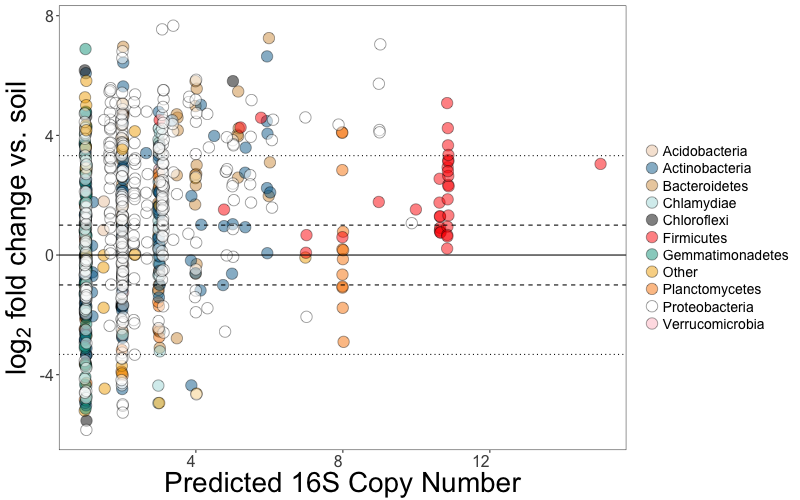

In [117]:
%%R -w 800 -h 500
# setting the image sizes, then making the figure...

d2 = d %>%
    filter(Trtmt=="Ferrihydrite")#%>%
    #mutate(SelectPhyla = ifelse(CommonPhyla %in% SelectPhy, CommonPhyla, "Other"))

p = ggplot(d2, aes(x = Copynum, y = l2FC, fill=CommonPhyla))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.
    
#p = p + geom_point(shape = 21, alpha=0.5, size=5)
p = p + geom_jitter(shape = 21, alpha=0.5, size=5,width=0.025)
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

#p = p + geom_abline(slope=m, intercept=b)
# puts in general fit line for all data points.. may not want this.

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 24),
              strip.text.y = element_text(size = 24),
              axis.text.x = element_text(size = 16,hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 28),
              axis.text.y = element_text(size=16),
              axis.title.y = element_text(size = 28),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Predicted 16S Copy Number")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
# sets the label for the y axes.

wes = c(wes_palette(name="Darjeeling2", 5, type = "discrete"),wes_palette(name="Darjeeling", 4, type = "discrete"),"white","pink")
p = p + scale_fill_manual(values=wes)

p = p + guides(fill=guide_legend(title=""))
#p = p + theme(legend.position=c(0.85,0.85))

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
   
p

In [118]:
%%R
ggsave(filename="16SCopyNum.F.jpg", plot=p ,width=8, height=7)